In [12]:
# Cell 1: EfficientViT PyTorch Implementation for Emotion Classification - Imports and Configuration
import os
import numpy as np
import pandas as pd
import cv2
import random
import time
import psutil
from datetime import timedelta, datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import Counter
from pathlib import Path
import pickle
import math

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F
from functools import partial

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

# GPU configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

# Configuration
IMG_SIZE = 224  # Standard input size for vision models
BATCH_SIZE = 32
EPOCHS = 100
VALIDATION_SPLIT = 0.3

# EfficientViT specific configuration
EFFICIENTVIT_CONFIG = {
    'base_learning_rate': 0.001,
    'fine_tune_learning_rate': 0.0001,
    'dropout_rate': 0.3,
    'fine_tune_layers': 30,
    'weight_decay': 1e-4,
    'patch_size': 16,
    'embed_dim': 192,
    'depth': 12,
    'num_heads': 3,
    'mlp_ratio': 4.0,
    'qkv_bias': True,
    'drop_rate': 0.1,
    'attn_drop_rate': 0.1,
    'drop_path_rate': 0.1,
    # Adicionar as configurações que estão faltando:
    'embed_dims': [64, 128, 192],  # Lista de dimensões para cada estágio
    'depths': [2, 4, 6],           # Lista de profundidades para cada estágio
    'num_heads': [2, 4, 6]         # Lista de cabeças de atenção para cada estágio
}

# Emotion labels mapping
EMOTION_LABELS = {
    'Raiva': 0, 'Nojo': 1, 'Medo': 2, 'Felicidade': 3, 
    'Neutro': 4, 'Tristeza': 5, 'Surpresa': 6
}

Using device: cuda
GPU: NVIDIA GeForce RTX 3060
CUDA version: 12.1
Memory: 11.6 GB


In [13]:
# Cell 2: Dataset and Core EfficientViT Components

class EmotionDataset(Dataset):
    """Custom dataset for emotion classification"""
    
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        # Convert numpy array to PIL Image format for transforms
        if isinstance(image, np.ndarray):
            # Ensure image is in uint8 format [0, 255]
            if image.max() <= 1.0:
                image = (image * 255).astype(np.uint8)
            else:
                image = image.astype(np.uint8)
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.long)

# EfficientViT core components
def drop_path(x, drop_prob: float = 0., training: bool = False):
    """Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks)."""
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()
    output = x.div(keep_prob) * random_tensor
    return output

class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks)."""
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)

class PatchEmbed(nn.Module):
    """2D Image to Patch Embedding with improved efficiency"""
    
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768, norm_layer=None):
        super().__init__()
        img_size = (img_size, img_size)
        patch_size = (patch_size, patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.grid_size = (img_size[0] // patch_size[0], img_size[1] // patch_size[1])
        self.num_patches = self.grid_size[0] * self.grid_size[1]

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.norm = norm_layer(embed_dim) if norm_layer else nn.Identity()

    def forward(self, x):
        B, C, H, W = x.shape
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x).flatten(2).transpose(1, 2)  # B Ph*Pw C
        x = self.norm(x)
        return x

class Mlp(nn.Module):
    """MLP as used in Vision Transformer, MLP-Mixer and related networks"""
    
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

In [14]:
# Cell 3: EfficientViT Attention and Block Components

class EfficientAttention(nn.Module):
    """Efficient Multi-Head Self-Attention with linear complexity"""
    
    def __init__(self, dim, num_heads=8, qkv_bias=False, attn_drop=0., proj_drop=0., sr_ratio=1):
        super().__init__()
        assert dim % num_heads == 0, f"dim {dim} should be divided by num_heads {num_heads}."

        self.dim = dim
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.q = nn.Linear(dim, dim, bias=qkv_bias)
        self.kv = nn.Linear(dim, dim * 2, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        self.sr_ratio = sr_ratio
        if sr_ratio > 1:
            self.sr = nn.Conv2d(dim, dim, kernel_size=sr_ratio, stride=sr_ratio)
            self.norm = nn.LayerNorm(dim)

    def forward(self, x, H, W):
        B, N, C = x.shape
        q = self.q(x).reshape(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)

        if self.sr_ratio > 1:
            x_ = x.permute(0, 2, 1).reshape(B, C, H, W)
            x_ = self.sr(x_).reshape(B, C, -1).permute(0, 2, 1)
            x_ = self.norm(x_)
            kv = self.kv(x_).reshape(B, -1, 2, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        else:
            kv = self.kv(x).reshape(B, -1, 2, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        k, v = kv[0], kv[1]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)

        return x

class EfficientViTBlock(nn.Module):
    """EfficientViT Transformer Block with efficient attention and MLP"""
    
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm, sr_ratio=1):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = EfficientAttention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, attn_drop=attn_drop, proj_drop=drop, sr_ratio=sr_ratio)
        
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x, H, W):
        x = x + self.drop_path(self.attn(self.norm1(x), H, W))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x

class EfficientViTStage(nn.Module):
    """EfficientViT Stage with multiple transformer blocks"""
    
    def __init__(self, dim, depth, num_heads, mlp_ratio, qkv_bias=True, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, sr_ratio=1):
        super().__init__()
        
        # stochastic depth decay rule
        dpr = [x.item() for x in torch.linspace(0, drop_path, depth)]
        
        self.blocks = nn.ModuleList([
            EfficientViTBlock(
                dim=dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias,
                drop=drop, attn_drop=attn_drop, drop_path=dpr[i], norm_layer=norm_layer,
                sr_ratio=sr_ratio)
            for i in range(depth)])

    def forward(self, x, H, W):
        for block in self.blocks:
            x = block(x, H, W)
        return x

In [15]:
# Cell 4: Main EfficientViT Model Architecture

class EfficientViTEmotionClassifier(nn.Module):
    """EfficientViT model for emotion classification"""
    
    def __init__(self, img_size=224, patch_size=16, in_chans=3, num_classes=7, embed_dims=[64, 128, 192], 
                 depths=[2, 4, 6], num_heads=[2, 4, 6], mlp_ratios=[4, 4, 4], qkv_bias=True,
                 drop_rate=0.1, attn_drop_rate=0.1, drop_path_rate=0.1, norm_layer=nn.LayerNorm,
                 sr_ratios=[8, 4, 2], dropout_rate=0.3):
        super().__init__()
        
        self.num_classes = num_classes
        self.depths = depths
        self.embed_dims = embed_dims
        
        # Patch embeddings for different stages
        self.patch_embed1 = PatchEmbed(
            img_size=img_size, patch_size=4, in_chans=in_chans, embed_dim=embed_dims[0])
        self.patch_embed2 = PatchEmbed(
            img_size=img_size // 4, patch_size=2, in_chans=embed_dims[0], embed_dim=embed_dims[1])
        self.patch_embed3 = PatchEmbed(
            img_size=img_size // 8, patch_size=2, in_chans=embed_dims[1], embed_dim=embed_dims[2])

        # Position embeddings
        self.pos_embed1 = nn.Parameter(torch.zeros(1, self.patch_embed1.num_patches, embed_dims[0]))
        self.pos_embed2 = nn.Parameter(torch.zeros(1, self.patch_embed2.num_patches, embed_dims[1]))
        self.pos_embed3 = nn.Parameter(torch.zeros(1, self.patch_embed3.num_patches, embed_dims[2]))
        
        self.pos_drop1 = nn.Dropout(p=drop_rate)
        self.pos_drop2 = nn.Dropout(p=drop_rate)
        self.pos_drop3 = nn.Dropout(p=drop_rate)

        # Stochastic depth decay rule
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]
        cur = 0

        # Stage 1
        self.stage1 = EfficientViTStage(
            dim=embed_dims[0], depth=depths[0], num_heads=num_heads[0], mlp_ratio=mlp_ratios[0],
            qkv_bias=qkv_bias, drop=drop_rate, attn_drop=attn_drop_rate,
            drop_path=drop_path_rate, sr_ratio=sr_ratios[0])
        cur += depths[0]

        # Stage 2
        self.stage2 = EfficientViTStage(
            dim=embed_dims[1], depth=depths[1], num_heads=num_heads[1], mlp_ratio=mlp_ratios[1],
            qkv_bias=qkv_bias, drop=drop_rate, attn_drop=attn_drop_rate,
            drop_path=drop_path_rate, sr_ratio=sr_ratios[1])
        cur += depths[1]

        # Stage 3
        self.stage3 = EfficientViTStage(
            dim=embed_dims[2], depth=depths[2], num_heads=num_heads[2], mlp_ratio=mlp_ratios[2],
            qkv_bias=qkv_bias, drop=drop_rate, attn_drop=attn_drop_rate,
            drop_path=drop_path_rate, sr_ratio=sr_ratios[2])

        # Norm layers
        self.norm1 = norm_layer(embed_dims[0])
        self.norm2 = norm_layer(embed_dims[1])
        self.norm3 = norm_layer(embed_dims[2])

        # Classification head with enhanced capacity
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.LayerNorm(embed_dims[2]),
            nn.Dropout(dropout_rate),
            nn.Linear(embed_dims[2], 512),
            nn.GELU(),
            nn.Dropout(dropout_rate * 0.5),
            nn.Linear(512, 256),
            nn.GELU(),
            nn.Dropout(dropout_rate * 0.3),
            nn.Linear(256, num_classes)
        )

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        """Initialize model weights"""
        for name, m in self.named_modules():
            if isinstance(m, nn.Linear):
                if 'classifier' in name:
                    nn.init.xavier_normal_(m.weight)
                    nn.init.constant_(m.bias, 0)
                else:
                    nn.init.trunc_normal_(m.weight, std=.02)
                    if m.bias is not None:
                        nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.bias, 0)
                nn.init.constant_(m.weight, 1.0)
            elif isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

        # Initialize position embeddings
        nn.init.trunc_normal_(self.pos_embed1, std=.02)
        nn.init.trunc_normal_(self.pos_embed2, std=.02)
        nn.init.trunc_normal_(self.pos_embed3, std=.02)

    def freeze_patch_emb(self):
        """Freeze patch embeddings for feature extraction phase"""
        for param in [self.pos_embed1, self.pos_embed2, self.pos_embed3]:
            param.requires_grad = False
        
        for module in [self.patch_embed1, self.patch_embed2, self.patch_embed3]:
            for param in module.parameters():
                param.requires_grad = False

    def freeze_stages(self, stages_to_freeze=[]):
        """Freeze specific stages"""
        stage_modules = [self.stage1, self.stage2, self.stage3]
        norm_modules = [self.norm1, self.norm2, self.norm3]
        
        for stage_idx in stages_to_freeze:
            if stage_idx < len(stage_modules):
                for param in stage_modules[stage_idx].parameters():
                    param.requires_grad = False
                for param in norm_modules[stage_idx].parameters():
                    param.requires_grad = False

    def unfreeze_last_stages(self, num_stages=1):
        """Unfreeze last stages for fine-tuning"""
        stage_modules = [self.stage1, self.stage2, self.stage3]
        norm_modules = [self.norm1, self.norm2, self.norm3]
        
        for i in range(max(0, len(stage_modules) - num_stages), len(stage_modules)):
            for param in stage_modules[i].parameters():
                param.requires_grad = True
            for param in norm_modules[i].parameters():
                param.requires_grad = True

    def forward_features(self, x):
        B = x.shape[0]
        
        # Stage 1
        x, (H, W) = self.patch_embed1(x), (self.patch_embed1.grid_size[0], self.patch_embed1.grid_size[1])
        x = x + self.pos_embed1
        x = self.pos_drop1(x)
        x = self.stage1(x, H, W)
        x = self.norm1(x)
        x = x.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()

        # Stage 2
        x, (H, W) = self.patch_embed2(x), (self.patch_embed2.grid_size[0], self.patch_embed2.grid_size[1])
        x = x + self.pos_embed2
        x = self.pos_drop2(x)
        x = self.stage2(x, H, W)
        x = self.norm2(x)
        x = x.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()

        # Stage 3
        x, (H, W) = self.patch_embed3(x), (self.patch_embed3.grid_size[0], self.patch_embed3.grid_size[1])
        x = x + self.pos_embed3
        x = self.pos_drop3(x)
        x = self.stage3(x, H, W)
        x = self.norm3(x)

        return x

    def forward(self, x):
        x = self.forward_features(x)
        
        # Global average pooling
        x = x.mean(dim=1)  # [B, embed_dim]
        
        # Classification
        x = self.classifier(x)
        
        return x

In [16]:

# Cell 5: EfficientViT Monitor and Data Loading Functions

class EfficientViTMonitor:
    """Monitor for EfficientViT training"""
    
    def __init__(self):
        self.start_time = None
        self.end_time = None
        self.peak_memory_mb = 0
        self.initial_memory_mb = 0
        self.phase1_time = 0
        self.phase2_time = 0
        self.process = psutil.Process()
        self.training_phases = {'phase1': None, 'phase2': None}
        
    def start_monitoring(self):
        """Start monitoring"""
        self.start_time = time.time()
        self.initial_memory_mb = self._get_memory_usage()
        self.peak_memory_mb = self.initial_memory_mb
        print(f"Starting EfficientViT training...")
        print(f"Start time: {time.strftime('%Y-%m-%d %H:%M:%S')}")
        print(f"Initial memory: {self.initial_memory_mb:.2f} MB")
        print(f"Device: {device}")
        print("-" * 50)
        
    def start_phase(self, phase_name):
        """Start a training phase"""
        self.training_phases[phase_name] = time.time()
        print(f"Starting {phase_name} - EfficientViT")
        
    def end_phase(self, phase_name):
        """End a training phase"""
        if self.training_phases[phase_name] is not None:
            phase_duration = time.time() - self.training_phases[phase_name]
            if phase_name == 'phase1':
                self.phase1_time = phase_duration
            elif phase_name == 'phase2':
                self.phase2_time = phase_duration
            print(f"{phase_name} completed in: {timedelta(seconds=int(phase_duration))}")
            return phase_duration
        return 0
        
    def _get_memory_usage(self):
        """Get current memory usage in MB"""
        return self.process.memory_info().rss / 1024 / 1024
        
    def update_peak_memory(self):
        """Update peak memory if necessary"""
        current_memory = self._get_memory_usage()
        if current_memory > self.peak_memory_mb:
            self.peak_memory_mb = current_memory
            
    def get_efficiency_metrics(self):
        """Calculate efficiency metrics"""
        current_memory = self._get_memory_usage()
        total_time = self.phase1_time + self.phase2_time
        
        return {
            'memory_efficiency': self.initial_memory_mb / self.peak_memory_mb if self.peak_memory_mb > 0 else 0,
            'time_efficiency': total_time / 3600,  # Hours
            'peak_memory_gb': self.peak_memory_mb / 1024,
            'memory_growth_factor': self.peak_memory_mb / self.initial_memory_mb if self.initial_memory_mb > 0 else 1,
            'phase1_ratio': self.phase1_time / total_time if total_time > 0 else 0,
            'phase2_ratio': self.phase2_time / total_time if total_time > 0 else 0
        }
        
    def end_monitoring(self):
        """End monitoring and return statistics"""
        self.end_time = time.time()
        
        total_time_seconds = self.end_time - self.start_time
        total_time_formatted = str(timedelta(seconds=int(total_time_seconds)))
        
        final_memory_mb = self._get_memory_usage()
        memory_increase = final_memory_mb - self.initial_memory_mb
        
        efficiency_metrics = self.get_efficiency_metrics()
        
        print("\n" + "="*70)
        print("EFFICIENTVIT MONITORING REPORT")
        print("="*70)
        print(f"Total training time: {total_time_formatted}")
        print(f"  • Phase 1 (Feature extraction): {timedelta(seconds=int(self.phase1_time))}")
        print(f"  • Phase 2 (Fine-tuning): {timedelta(seconds=int(self.phase2_time))}")
        print(f"Initial memory: {self.initial_memory_mb:.2f} MB")
        print(f"Final memory: {final_memory_mb:.2f} MB")
        print(f"Peak memory: {self.peak_memory_mb:.2f} MB")
        print(f"Memory efficiency: {efficiency_metrics['memory_efficiency']:.3f}")
        print(f"Growth factor: {efficiency_metrics['memory_growth_factor']:.2f}x")
        print("="*70)
        
        return {
            'total_time_seconds': total_time_seconds,
            'total_time_formatted': total_time_formatted,
            'initial_memory_mb': self.initial_memory_mb,
            'final_memory_mb': final_memory_mb,
            'peak_memory_mb': self.peak_memory_mb,
            'memory_increase_mb': memory_increase,
            'phase1_time': self.phase1_time,
            'phase2_time': self.phase2_time,
            'efficiency_metrics': efficiency_metrics
        }

def load_preprocessed_data_efficientvit_from_images():
    """Load preprocessed data from images for EfficientViT"""
    print("Loading preprocessed JPG data for EfficientViT...")
    
    #BASE_PATH = r"../data/augmented/raf_db_balanced"
    BASE_PATH = r"../data/raw/RAF-DB/DATASET"
    
    def load_images_from_directory(directory_path, set_name):
        """Load images from directory"""
        images = []
        labels = []
        
        print(f"Loading {set_name} from: {directory_path}")
        
        if not os.path.exists(directory_path):
            print(f"❌ Directory not found: {directory_path}")
            return np.array([]), np.array([])
        
        subdirs = [d for d in os.listdir(directory_path) 
                  if os.path.isdir(os.path.join(directory_path, d))]
        
        print(f"📁 Subdirectories found: {subdirs}")
        
        for emotion, label in EMOTION_LABELS.items():
            emotion_path = os.path.join(directory_path, emotion)
            
            if not os.path.exists(emotion_path):
                print(f"⚠️ Folder '{emotion}' not found in {directory_path}")
                continue
            
            count = 0
            image_files = [f for f in os.listdir(emotion_path) 
                          if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            
            for image_file in image_files:
                try:
                    image_path = os.path.join(emotion_path, image_file)
                    image = cv2.imread(image_path)
                    
                    if image is not None:
                        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
                        images.append(image)
                        labels.append(label)
                        count += 1
                    
                except Exception as e:
                    print(f"Error loading {image_path}: {e}")
                    continue
            
            print(f"  • {emotion}: {count} images loaded")
        
        return np.array(images), np.array(labels)
    
    # Load training data
    train_path = os.path.join(BASE_PATH, "train")
    X_train, y_train = load_images_from_directory(train_path, "training")
    
    # Load test data  
    test_path = os.path.join(BASE_PATH, "test")
    X_test, y_test = load_images_from_directory(test_path, "test")
    
    if len(X_train) == 0 or len(X_test) == 0:
        print("❌ Failed to load data. Check directory structure.")
        return None, None, None, None
    
    print(f"\n✅ Data loaded successfully:")
    print(f"  • Training: {X_train.shape}")
    print(f"  • Test: {X_test.shape}")
    
    return X_train, y_train, X_test, y_test

In [17]:
# Cell 6: Data Transforms and Training Functions

def get_transforms():
    """Get transforms for training and validation with ViT-specific augmentations"""
    # Training transforms with augmentation optimized for ViT
    train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomAutocontrast(p=0.3),
        transforms.RandomEqualize(p=0.3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet normalization
        transforms.RandomErasing(p=0.1, scale=(0.02, 0.2))  # Random erasing for better generalization
    ])
    
    # Validation/test transforms (no augmentation)
    val_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    return train_transform, val_transform

def create_data_loaders(X_train, y_train, X_val, y_val, X_test, y_test):
    """Create PyTorch data loaders"""
    train_transform, val_transform = get_transforms()
    
    # Create datasets
    train_dataset = EmotionDataset(X_train, y_train, transform=train_transform)
    val_dataset = EmotionDataset(X_val, y_val, transform=val_transform)
    test_dataset = EmotionDataset(X_test, y_test, transform=val_transform)
    
    # Create data loaders with appropriate workers
    num_workers = min(4, os.cpu_count() or 1)
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                             num_workers=num_workers, pin_memory=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                           num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                            num_workers=num_workers, pin_memory=True)
    
    return train_loader, val_loader, test_loader

def train_one_epoch(model, train_loader, criterion, optimizer, device, epoch):
    """Train for one epoch with gradient clipping for stability"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        
        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
        
        if batch_idx % 50 == 0:
            print(f'Epoch {epoch}, Batch {batch_idx}/{len(train_loader)}, '
                  f'Loss: {loss.item():.4f}, Acc: {100.*correct/total:.2f}%')
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

def validate(model, val_loader, criterion, device):
    """Validate the model"""
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
            output = model(data)
            val_loss += criterion(output, target).item()
            
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    val_loss /= len(val_loader)
    val_acc = 100. * correct / total
    
    return val_loss, val_acc

In [18]:
# Cell 7: Two-Phase Training for EfficientViT

def train_efficientvit_two_phase(model, train_loader, val_loader, monitor):
    """Train EfficientViT in two phases"""
    print("="*60)
    print("STARTING EFFICIENTVIT 2-PHASE TRAINING")
    print("="*60)
    
    # Phase 1: Feature extraction with frozen backbone
    print("PHASE 1: FEATURE EXTRACTION")
    print("-" * 40)
    monitor.start_phase('phase1')
    
    # Freeze patch embeddings and most stages, only train classifier
    model.freeze_patch_emb()
    model.freeze_stages([0, 1])  # Freeze first two stages
    
    # Setup optimizer and criterion for phase 1
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # Label smoothing for better generalization
    
    # Only optimize unfrozen parameters
    trainable_params = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.AdamW(trainable_params, lr=EFFICIENTVIT_CONFIG['base_learning_rate'], 
                           weight_decay=EFFICIENTVIT_CONFIG['weight_decay'], betas=(0.9, 0.999))
    
    # Cosine annealing scheduler
    phase1_epochs = 25
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=phase1_epochs, eta_min=1e-6)
    
    # Early stopping
    best_val_acc_phase1 = 0
    patience_counter = 0
    patience = 8
    
    history_phase1 = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    print(f"Training {len(trainable_params)} parameters in Phase 1")
    
    for epoch in range(phase1_epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, epoch + 1)
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        
        scheduler.step()
        
        history_phase1['train_loss'].append(train_loss)
        history_phase1['train_acc'].append(train_acc)
        history_phase1['val_loss'].append(val_loss)
        history_phase1['val_acc'].append(val_acc)
        
        if val_acc > best_val_acc_phase1:
            best_val_acc_phase1 = val_acc
            patience_counter = 0
            # Save phase 1 best model
            torch.save(model.state_dict(), 'best_efficientvit_phase1.pth')
        else:
            patience_counter += 1
        
        if epoch % 3 == 0:
            print(f'Phase 1 - Epoch {epoch+1}: Train Loss: {train_loss:.4f}, '
                  f'Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        
        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    phase1_duration = monitor.end_phase('phase1')
    print(f"Phase 1 - Best val_accuracy: {best_val_acc_phase1:.4f}")
    
    # Load best phase 1 model
    model.load_state_dict(torch.load('best_efficientvit_phase1.pth'))
    
    # Phase 2: Fine-tuning
    print("\nPHASE 2: FINE-TUNING")
    print("-" * 40)
    monitor.start_phase('phase2')
    
    # Unfreeze more layers for fine-tuning
    model.unfreeze_last_stages(2)  # Unfreeze last 2 stages
    
    # Setup optimizer for phase 2 with lower learning rate and different parameters
    trainable_params = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.AdamW(trainable_params, lr=EFFICIENTVIT_CONFIG['fine_tune_learning_rate'], 
                           weight_decay=EFFICIENTVIT_CONFIG['weight_decay'], betas=(0.9, 0.999))
    
    # Scheduler with warm restarts
    phase2_epochs = EPOCHS - phase1_epochs if phase1_epochs < EPOCHS else 35
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=10, T_mult=2, eta_min=1e-7)
    
    # Training phase 2
    best_val_acc_phase2 = 0
    patience_counter = 0
    patience = 12
    
    history_phase2 = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    print(f"Training {len(trainable_params)} parameters in Phase 2")
    
    for epoch in range(phase2_epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, epoch + 1)
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        
        scheduler.step()
        
        history_phase2['train_loss'].append(train_loss)
        history_phase2['train_acc'].append(train_acc)
        history_phase2['val_loss'].append(val_loss)
        history_phase2['val_acc'].append(val_acc)
        
        if val_acc > best_val_acc_phase2:
            best_val_acc_phase2 = val_acc
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), 'best_efficientvit_model.pth')
        else:
            patience_counter += 1
        
        if epoch % 3 == 0:
            print(f'Phase 2 - Epoch {epoch+1}: Train Loss: {train_loss:.4f}, '
                  f'Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        
        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    phase2_duration = monitor.end_phase('phase2')
    print(f"Phase 2 - Best val_accuracy: {best_val_acc_phase2:.4f}")
    
    # Combine histories
    combined_history = {
        'train_loss': history_phase1['train_loss'] + history_phase2['train_loss'],
        'train_acc': history_phase1['train_acc'] + history_phase2['train_acc'],
        'val_loss': history_phase1['val_loss'] + history_phase2['val_loss'],
        'val_acc': history_phase1['val_acc'] + history_phase2['val_acc'],
        'phase1_epochs': len(history_phase1['train_loss']),
        'phase2_epochs': len(history_phase2['train_loss']),
        'phase1_duration': phase1_duration,
        'phase2_duration': phase2_duration,
        'best_val_acc_phase1': best_val_acc_phase1,
        'best_val_acc_phase2': best_val_acc_phase2
    }
    
    print(f"\nTRAINING COMPLETE:")
    print(f"  • Total epochs: {combined_history['phase1_epochs'] + combined_history['phase2_epochs']}")
    print(f"  • Best final accuracy: {max(combined_history['val_acc']):.4f}")
    print(f"  • Total time: {timedelta(seconds=int(phase1_duration + phase2_duration))}")
    
    return combined_history

def evaluate_model(model, test_loader, device):
    """Evaluate model on test set with detailed metrics"""
    model.eval()
    all_preds = []
    all_targets = []
    all_probs = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
            output = model(data)
            probs = F.softmax(output, dim=1)
            _, predicted = output.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_targets, all_preds)
    precision, recall, f1, support = precision_recall_fscore_support(
        all_targets, all_preds, average='macro', zero_division=0
    )
    
    # Confusion matrix
    conf_matrix = confusion_matrix(all_targets, all_preds)
    
    # Classification report
    emotion_names = list(EMOTION_LABELS.keys())
    class_report = classification_report(
        all_targets, all_preds,
        target_names=emotion_names,
        output_dict=True
    )
    
    return accuracy, f1, precision, recall, conf_matrix, class_report, np.array(all_probs)

In [19]:
# Cell 8 Detailed Analysis Functions

def print_detailed_imbalance_analysis(y_true, y_pred, conf_matrix, class_report, emotion_names):
    """Detailed textual analysis of imbalance impact"""
    
    print("\n" + "="*80)
    print("DETAILED ANALYSIS - IMBALANCED DATA")
    print("="*80)
    
    # Imbalance statistics
    unique, counts = np.unique(y_true, return_counts=True)
    class_distribution = dict(zip(unique, counts))
    
    print("CLASS DISTRIBUTION:")
    total_samples = len(y_true)
    for i, emotion in enumerate(emotion_names):
        count = class_distribution.get(i, 0)
        percentage = (count / total_samples) * 100
        print(f"  • {emotion}: {count} samples ({percentage:.1f}%)")
    
    # Imbalance analysis
    max_samples = max(counts)
    min_samples = min(counts)
    imbalance_ratio = max_samples / min_samples
    class_std = np.std(counts)
    class_cv = class_std / np.mean(counts)
    
    print(f"\nIMBALANCE STATISTICS:")
    print(f"  • Maximum/minimum ratio: {imbalance_ratio:.2f}x")
    print(f"  • Standard deviation: {class_std:.1f} samples")
    print(f"  • Coefficient of variation: {class_cv:.3f}")
    print(f"  • Majority class: {emotion_names[np.argmax(counts)]} ({max_samples} samples)")
    print(f"  • Minority class: {emotion_names[np.argmin(counts)]} ({min_samples} samples)")
    
    # Performance impact
    print(f"\nPERFORMANCE IMPACT:")
    f1_scores = [class_report[emotion]['f1-score'] for emotion in emotion_names]
    support_counts = [class_report[emotion]['support'] for emotion in emotion_names]
    
    # Correlation between quantity and performance
    correlation = np.corrcoef(support_counts, f1_scores)[0, 1]
    print(f"  • Correlation samples-F1: {correlation:.3f}")
    
    if correlation > 0.5:
        print(f"    → STRONG positive correlation: more samples = better F1")
    elif correlation > 0.3:
        print(f"    → MODERATE positive correlation")
    elif correlation > -0.3:
        print(f"    → WEAK correlation: model relatively robust")
    else:
        print(f"    → Negative correlation: possible overfitting on majority classes")
    
    # Best/worst performing classes
    best_class_idx = np.argmax(f1_scores)
    worst_class_idx = np.argmin(f1_scores)
    
    print(f"  • Best F1: {emotion_names[best_class_idx]} ({f1_scores[best_class_idx]:.3f}) - {support_counts[best_class_idx]} samples")
    print(f"  • Worst F1: {emotion_names[worst_class_idx]} ({f1_scores[worst_class_idx]:.3f}) - {support_counts[worst_class_idx]} samples")
    
    # Confusion analysis
    print(f"\nMAJOR CONFUSIONS:")
    conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    conf_matrix_norm = np.nan_to_num(conf_matrix_norm)
    
    # Find biggest errors (off-diagonal)
    np.fill_diagonal(conf_matrix_norm, 0)
    max_confusion_idx = np.unravel_index(np.argmax(conf_matrix_norm), conf_matrix_norm.shape)
    max_confusion_value = conf_matrix_norm[max_confusion_idx]
    
    print(f"  • {emotion_names[max_confusion_idx[0]]} → {emotion_names[max_confusion_idx[1]]}: {max_confusion_value:.3f}")
    
    # Top 3 confusions
    flat_indices = np.argsort(conf_matrix_norm.flatten())[-3:][::-1]
    for idx in flat_indices:
        i, j = np.unravel_index(idx, conf_matrix_norm.shape)
        if i != j:  # Ignore diagonal
            print(f"  • {emotion_names[i]} → {emotion_names[j]}: {conf_matrix_norm[i, j]:.3f}")
    
    # Recommendations
    print(f"\nRECOMMENDATIONS:")
    if imbalance_ratio > 10:
        print("  • SEVERE imbalance - consider balancing techniques")
        print("  • Suggestions: SMOTE, class weighting, focal loss")
    elif imbalance_ratio > 5:
        print("  • MODERATE imbalance - monitor per-class metrics")
        print("  • Suggestions: class weighting, stratified sampling")
    else:
        print("  • MILD imbalance - model can handle adequately")
    
    if correlation < 0.3:
        print("  • Model shows robustness to imbalance")
        print("  • Vision Transformer attention mechanism helps")
    else:
        print("  • Consider strategies for minority classes")
        print("  • Data augmentation for underrepresented emotions")
    
    print("="*80)

In [20]:
# Cell 9 Comprehensive Visualizations for EfficientViT

def create_comprehensive_visualizations_efficientvit_pytorch(history, conf_matrix, metrics, class_report, experiment_id, y_true, y_pred):
    """
    Creates comprehensive visualizations for EfficientViT results with focus on imbalanced data
    
    Args:
        history: Training history
        conf_matrix: Confusion matrix
        metrics: Model metrics
        class_report: Classification report
        experiment_id: Experiment ID
        y_true: True labels
        y_pred: Model predictions
    """
    
    # Figure configuration
    fig = plt.figure(figsize=(24, 18))
    
    # 1. TRAINING HISTORY IN 2 PHASES
    ax1 = plt.subplot(3, 4, 1)
    epochs_phase1 = range(1, history['phase1_epochs'] + 1)
    epochs_phase2 = range(history['phase1_epochs'] + 1, 
                         history['phase1_epochs'] + history['phase2_epochs'] + 1)
    
    # Plot accuracy by phase
    plt.plot(epochs_phase1, history['train_acc'][:history['phase1_epochs']], 
             'b-', linewidth=2, label='Phase 1 - Train')
    plt.plot(epochs_phase1, history['val_acc'][:history['phase1_epochs']], 
             'b--', linewidth=2, label='Phase 1 - Val')
    plt.plot(epochs_phase2, history['train_acc'][history['phase1_epochs']:], 
             'r-', linewidth=2, label='Phase 2 - Train')
    plt.plot(epochs_phase2, history['val_acc'][history['phase1_epochs']:], 
             'r--', linewidth=2, label='Phase 2 - Val')
    
    plt.axvline(x=history['phase1_epochs'], color='gray', linestyle=':', alpha=0.7, 
                label='Phase Transition')
    plt.title('EfficientViT: Accuracy - 2 Phases', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # 2. LOSS IN 2 PHASES
    ax2 = plt.subplot(3, 4, 2)
    plt.plot(epochs_phase1, history['train_loss'][:history['phase1_epochs']], 
             'b-', linewidth=2, label='Phase 1 - Train')
    plt.plot(epochs_phase1, history['val_loss'][:history['phase1_epochs']], 
             'b--', linewidth=2, label='Phase 1 - Val')
    plt.plot(epochs_phase2, history['train_loss'][history['phase1_epochs']:], 
             'r-', linewidth=2, label='Phase 2 - Train')
    plt.plot(epochs_phase2, history['val_loss'][history['phase1_epochs']:], 
             'r--', linewidth=2, label='Phase 2 - Val')
    
    plt.axvline(x=history['phase1_epochs'], color='gray', linestyle=':', alpha=0.7)
    plt.title('EfficientViT: Loss - 2 Phases', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # 3. RAW CONFUSION MATRIX (SHOWS IMBALANCE)
    ax3 = plt.subplot(3, 4, 3)
    emotion_names = list(EMOTION_LABELS.keys())
    
    # Raw matrix shows imbalance
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=emotion_names, yticklabels=emotion_names, ax=ax3,
                cbar_kws={'label': 'Number of Samples'})
    plt.title('Raw Confusion Matrix\n(Shows Imbalance)', fontsize=12, fontweight='bold')
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    
    # 4. NORMALIZED CONFUSION MATRIX (BY ROW)
    ax4 = plt.subplot(3, 4, 4)
    
    # Row normalization (recall per class)
    conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    conf_matrix_norm = np.nan_to_num(conf_matrix_norm)
    
    sns.heatmap(conf_matrix_norm, annot=True, fmt='.3f', cmap='Greens',
                xticklabels=emotion_names, yticklabels=emotion_names, ax=ax4,
                cbar_kws={'label': 'Proportion (Recall)'})
    plt.title('Normalized Confusion Matrix\n(Recall per Class)', fontsize=12, fontweight='bold')
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    
    # 5. CLASS DISTRIBUTION (IMBALANCE)
    ax5 = plt.subplot(3, 4, 5)
    
    # Count samples per class in test set
    unique, counts = np.unique(y_true, return_counts=True)
    class_distribution = dict(zip(unique, counts))
    
    # Sort by quantity
    sorted_classes = sorted(class_distribution.items(), key=lambda x: x[1], reverse=True)
    class_names_sorted = [emotion_names[i] for i, count in sorted_classes]
    class_counts_sorted = [count for i, count in sorted_classes]
    
    colors = plt.cm.Set3(np.linspace(0, 1, len(class_names_sorted)))
    bars = plt.bar(class_names_sorted, class_counts_sorted, color=colors, alpha=0.8, edgecolor='black')
    
    plt.title('Class Distribution - Test\n(Imbalanced Data)', fontsize=12, fontweight='bold')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45)
    
    # Add values on bars
    for bar, count in zip(bars, class_counts_sorted):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                f'{count}', ha='center', va='bottom', fontweight='bold')
    
    # Add mean line
    mean_samples = np.mean(class_counts_sorted)
    plt.axhline(y=mean_samples, color='red', linestyle='--', alpha=0.7, 
                label=f'Mean: {mean_samples:.1f}')
    plt.legend()
    
    # 6. F1-SCORE PER EMOTION WITH IMBALANCE ANALYSIS
    ax6 = plt.subplot(3, 4, 6)
    
    f1_scores = [class_report[emotion]['f1-score'] for emotion in emotion_names]
    support_counts = [class_report[emotion]['support'] for emotion in emotion_names]
    
    # Create colored bar chart by sample count
    colors = plt.cm.viridis(np.array(support_counts) / max(support_counts))
    bars = plt.bar(emotion_names, f1_scores, color=colors, alpha=0.8, edgecolor='black')
    
    plt.title('F1-Score per Emotion\n(Color = Sample Count)', fontsize=12, fontweight='bold')
    plt.ylabel('F1-Score')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    
    # Add values and support
    for bar, score, support in zip(bars, f1_scores, support_counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{score:.3f}\n(n={support})', ha='center', va='bottom', fontsize=9)
    
    # Colorbar to indicate sample count
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, 
                               norm=plt.Normalize(vmin=min(support_counts), vmax=max(support_counts)))
    sm.set_array([])
    plt.colorbar(sm, ax=ax6, label='Test Samples')
    
    # 7. PRECISION, RECALL, F1 PER CLASS
    ax7 = plt.subplot(3, 4, 7)
    
    precision_scores = [class_report[emotion]['precision'] for emotion in emotion_names]
    recall_scores = [class_report[emotion]['recall'] for emotion in emotion_names]
    
    x = np.arange(len(emotion_names))
    width = 0.25
    
    bars1 = plt.bar(x - width, precision_scores, width, label='Precision', alpha=0.8, color='lightcoral')
    bars2 = plt.bar(x, recall_scores, width, label='Recall', alpha=0.8, color='lightblue')
    bars3 = plt.bar(x + width, f1_scores, width, label='F1-Score', alpha=0.8, color='lightgreen')
    
    plt.title('Detailed Metrics per Class', fontsize=12, fontweight='bold')
    plt.ylabel('Score')
    plt.xlabel('Emotion')
    plt.xticks(x, emotion_names, rotation=45)
    plt.legend()
    plt.ylim(0, 1)
    
    # 8. IMBALANCE vs PERFORMANCE CORRELATION
    ax8 = plt.subplot(3, 4, 8)
    
    # Scatter plot: Sample count vs F1-Score
    plt.scatter(support_counts, f1_scores, c=support_counts, cmap='viridis', 
                s=100, alpha=0.7, edgecolors='black')
    
    # Add labels for each point
    for i, emotion in enumerate(emotion_names):
        plt.annotate(emotion, (support_counts[i], f1_scores[i]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    # Trend line
    z = np.polyfit(support_counts, f1_scores, 1)
    p = np.poly1d(z)
    plt.plot(support_counts, p(support_counts), "r--", alpha=0.8)
    
    plt.title('Samples vs Performance\n(Correlation)', fontsize=12, fontweight='bold')
    plt.xlabel('Number of Test Samples')
    plt.ylabel('F1-Score')
    plt.grid(True, alpha=0.3)
    
    # Calculate correlation
    correlation = np.corrcoef(support_counts, f1_scores)[0, 1]
    plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
             transform=ax8.transAxes, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # 9. ERROR HEATMAP PER CLASS
    ax9 = plt.subplot(3, 4, 9)
    
    # Error matrix (off-diagonal elements)
    error_matrix = conf_matrix.copy()
    np.fill_diagonal(error_matrix, 0)  # Remove diagonal (correct predictions)
    
    # Normalize by row to show proportion of errors
    error_matrix_norm = error_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    error_matrix_norm = np.nan_to_num(error_matrix_norm)
    
    sns.heatmap(error_matrix_norm, annot=True, fmt='.3f', cmap='Reds',
                xticklabels=emotion_names, yticklabels=emotion_names, ax=ax9,
                cbar_kws={'label': 'Error Proportion'})
    plt.title('Error Heatmap\n(Class Confusions)', fontsize=12, fontweight='bold')
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class (Error)')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    
    # 10. COMPARATIVE METRICS: WEIGHTED vs MACRO
    ax10 = plt.subplot(3, 4, 10)
    
    # Calculate weighted and macro metrics
    from sklearn.metrics import precision_recall_fscore_support
    
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro', zero_division=0)
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
        y_true, y_pred, average='weighted', zero_division=0)
    
    metrics_comparison = {
        'Precision': [precision_macro, precision_weighted],
        'Recall': [recall_macro, recall_weighted],
        'F1-Score': [f1_macro, f1_weighted]
    }
    
    x = np.arange(len(metrics_comparison))
    width = 0.35
    
    macro_values = [metrics_comparison[metric][0] for metric in metrics_comparison]
    weighted_values = [metrics_comparison[metric][1] for metric in metrics_comparison]
    
    bars1 = plt.bar(x - width/2, macro_values, width, label='Macro (Unbalanced)', 
                   alpha=0.8, color='lightcoral')
    bars2 = plt.bar(x + width/2, weighted_values, width, label='Weighted (Balanced)', 
                   alpha=0.8, color='lightblue')
    
    plt.title('Macro vs Weighted Metrics\n(Imbalance Impact)', fontsize=12, fontweight='bold')
    plt.ylabel('Score')
    plt.xlabel('Metric')
    plt.xticks(x, metrics_comparison.keys())
    plt.legend()
    plt.ylim(0, 1)
    
    # Add values on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=10)
    
    # 11. COMPUTATIONAL RESOURCES AND EFFICIENCY
    ax11 = plt.subplot(3, 4, 11)
    
    resource_data = {
        'Time (min)': metrics['training_time_seconds'] / 60,
        'Memory (GB)': metrics['peak_memory_mb'] / 1024,
        'Parameters (M)': metrics['total_parameters'] / 1_000_000,
        'Efficiency\n(Acc/M_params)': metrics['test_accuracy'] / (metrics['total_parameters'] / 1_000_000)
    }
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    bars = plt.bar(range(len(resource_data)), list(resource_data.values()), 
                  color=colors, alpha=0.7, edgecolor='black')
    
    plt.title('Computational Resources\nEfficientViT', fontsize=12, fontweight='bold')
    plt.xticks(range(len(resource_data)), resource_data.keys(), rotation=45)
    plt.ylabel('Value')
    
    # Add values on bars
    for bar, (key, value) in zip(bars, resource_data.items()):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + bar.get_height()*0.02,
                f'{value:.2f}', ha='center', va='bottom', fontweight='bold')
    
    # 12. SCIENTIFIC SUMMARY
    ax12 = plt.subplot(3, 4, 12)
    ax12.axis('off')
    
    # Calculate imbalance statistics
    imbalance_ratio = max(support_counts) / min(support_counts)
    class_std = np.std(support_counts)
    class_cv = class_std / np.mean(support_counts)  # Coefficient of variation
    
    summary_text = f"""
EFFICIENTVIT PYTORCH
SCIENTIFIC ANALYSIS

PERFORMANCE:
• Accuracy: {metrics['test_accuracy']:.4f}
• F1-Macro: {f1_macro:.4f}
• F1-Weighted: {f1_weighted:.4f}

IMBALANCE:
• Ratio max/min: {imbalance_ratio:.1f}x
• Coef. Variation: {class_cv:.3f}
• Correlation samples-F1: {correlation:.3f}

EFFICIENCY:
• Parameters: {metrics['total_parameters']/1_000_000:.1f}M
• Time: {metrics['training_time_seconds']/60:.1f} min
• Memory: {metrics['peak_memory_mb']/1024:.2f} GB

VISION TRANSFORMER:
• Multi-head attention layers
• Patch-based processing
• Hierarchical feature learning

CONCLUSION:
Model {'robust' if f1_macro > 0.7 else 'limited'} for imbalanced
data. {'Good' if correlation > 0.3 else 'Low'} correlation
between sample count and performance.
Attention mechanism handles spatial
relationships effectively.
    """
    
    ax12.text(0.05, 0.95, summary_text, fontsize=10, verticalalignment='top',
             transform=ax12.transAxes,
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
    
    plt.tight_layout()
    
    # Save figure
    os.makedirs('plots/efficientvit', exist_ok=True)
    plt.savefig(f'plots/efficientvit/efficientvit_comprehensive_analysis_pytorch_{experiment_id}.png', 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    # === DETAILED TEXTUAL ANALYSIS ===
    print_detailed_imbalance_analysis(y_true, y_pred, conf_matrix, class_report, emotion_names)

Starting EfficientViT training...
Start time: 2025-09-18 19:52:39
Initial memory: 698.19 MB
Device: cuda
--------------------------------------------------
Experiment ID: efficientvit_pytorch_emotion_20250918_195239
Loading data...
Loading preprocessed JPG data for EfficientViT...
Loading training from: ../data/raw/RAF-DB/DATASET/train
📁 Subdirectories found: ['Felicidade', 'Surpresa', 'Raiva', 'Tristeza', 'Medo', 'Nojo', 'Neutro']
  • Raiva: 705 images loaded
  • Nojo: 717 images loaded
  • Medo: 281 images loaded
  • Felicidade: 4772 images loaded
  • Neutro: 2524 images loaded
  • Tristeza: 1982 images loaded
  • Surpresa: 1290 images loaded
Loading test from: ../data/raw/RAF-DB/DATASET/test
📁 Subdirectories found: ['Felicidade', 'Surpresa', 'Raiva', 'Tristeza', 'Medo', 'Nojo', 'Neutro']
  • Raiva: 162 images loaded
  • Nojo: 160 images loaded
  • Medo: 74 images loaded
  • Felicidade: 1185 images loaded
  • Neutro: 680 images loaded
  • Tristeza: 478 images loaded
  • Surpresa: 329

/tmp/ipykernel_37449/3388888548.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_efficientvit_phase1.pth'))


Epoch 1, Batch 0/268, Loss: 1.7173, Acc: 40.62%
Epoch 1, Batch 50/268, Loss: 1.6696, Acc: 40.93%
Epoch 1, Batch 100/268, Loss: 1.6915, Acc: 39.79%
Epoch 1, Batch 150/268, Loss: 1.9231, Acc: 39.11%
Epoch 1, Batch 200/268, Loss: 1.5049, Acc: 39.13%
Epoch 1, Batch 250/268, Loss: 1.7306, Acc: 39.40%
Phase 2 - Epoch 1: Train Loss: 1.6769, Train Acc: 39.34%, Val Loss: 1.6775, Val Acc: 39.79%
Epoch 2, Batch 0/268, Loss: 1.7022, Acc: 43.75%
Epoch 2, Batch 50/268, Loss: 1.6422, Acc: 38.48%
Epoch 2, Batch 100/268, Loss: 1.5352, Acc: 39.45%
Epoch 2, Batch 150/268, Loss: 1.6405, Acc: 39.47%
Epoch 2, Batch 200/268, Loss: 1.7034, Acc: 39.18%
Epoch 2, Batch 250/268, Loss: 1.5516, Acc: 39.50%
Epoch 3, Batch 0/268, Loss: 1.7115, Acc: 40.62%
Epoch 3, Batch 50/268, Loss: 1.7272, Acc: 38.79%
Epoch 3, Batch 100/268, Loss: 1.6555, Acc: 38.77%
Epoch 3, Batch 150/268, Loss: 1.5958, Acc: 38.97%
Epoch 3, Batch 200/268, Loss: 1.7042, Acc: 39.19%
Epoch 3, Batch 250/268, Loss: 1.6641, Acc: 39.32%
Epoch 4, Batch 0/

/tmp/ipykernel_37449/3074327645.py:98: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_efficientvit_model.pth'))
/home/leandro/Documents


COMPREHENSIVE RESULTS:
  • Test Accuracy: 0.4791 (47.91%)
  • F1-Score (Macro): 0.1862
  • F1-Score (Weighted): 0.3914
  • Precision (Macro): 0.1781
  • Recall (Macro): 0.2250
  • Inference Speed: 5412.1 samples/second
  • Total Training Time: 0:55:32

Generating comprehensive visualizations...


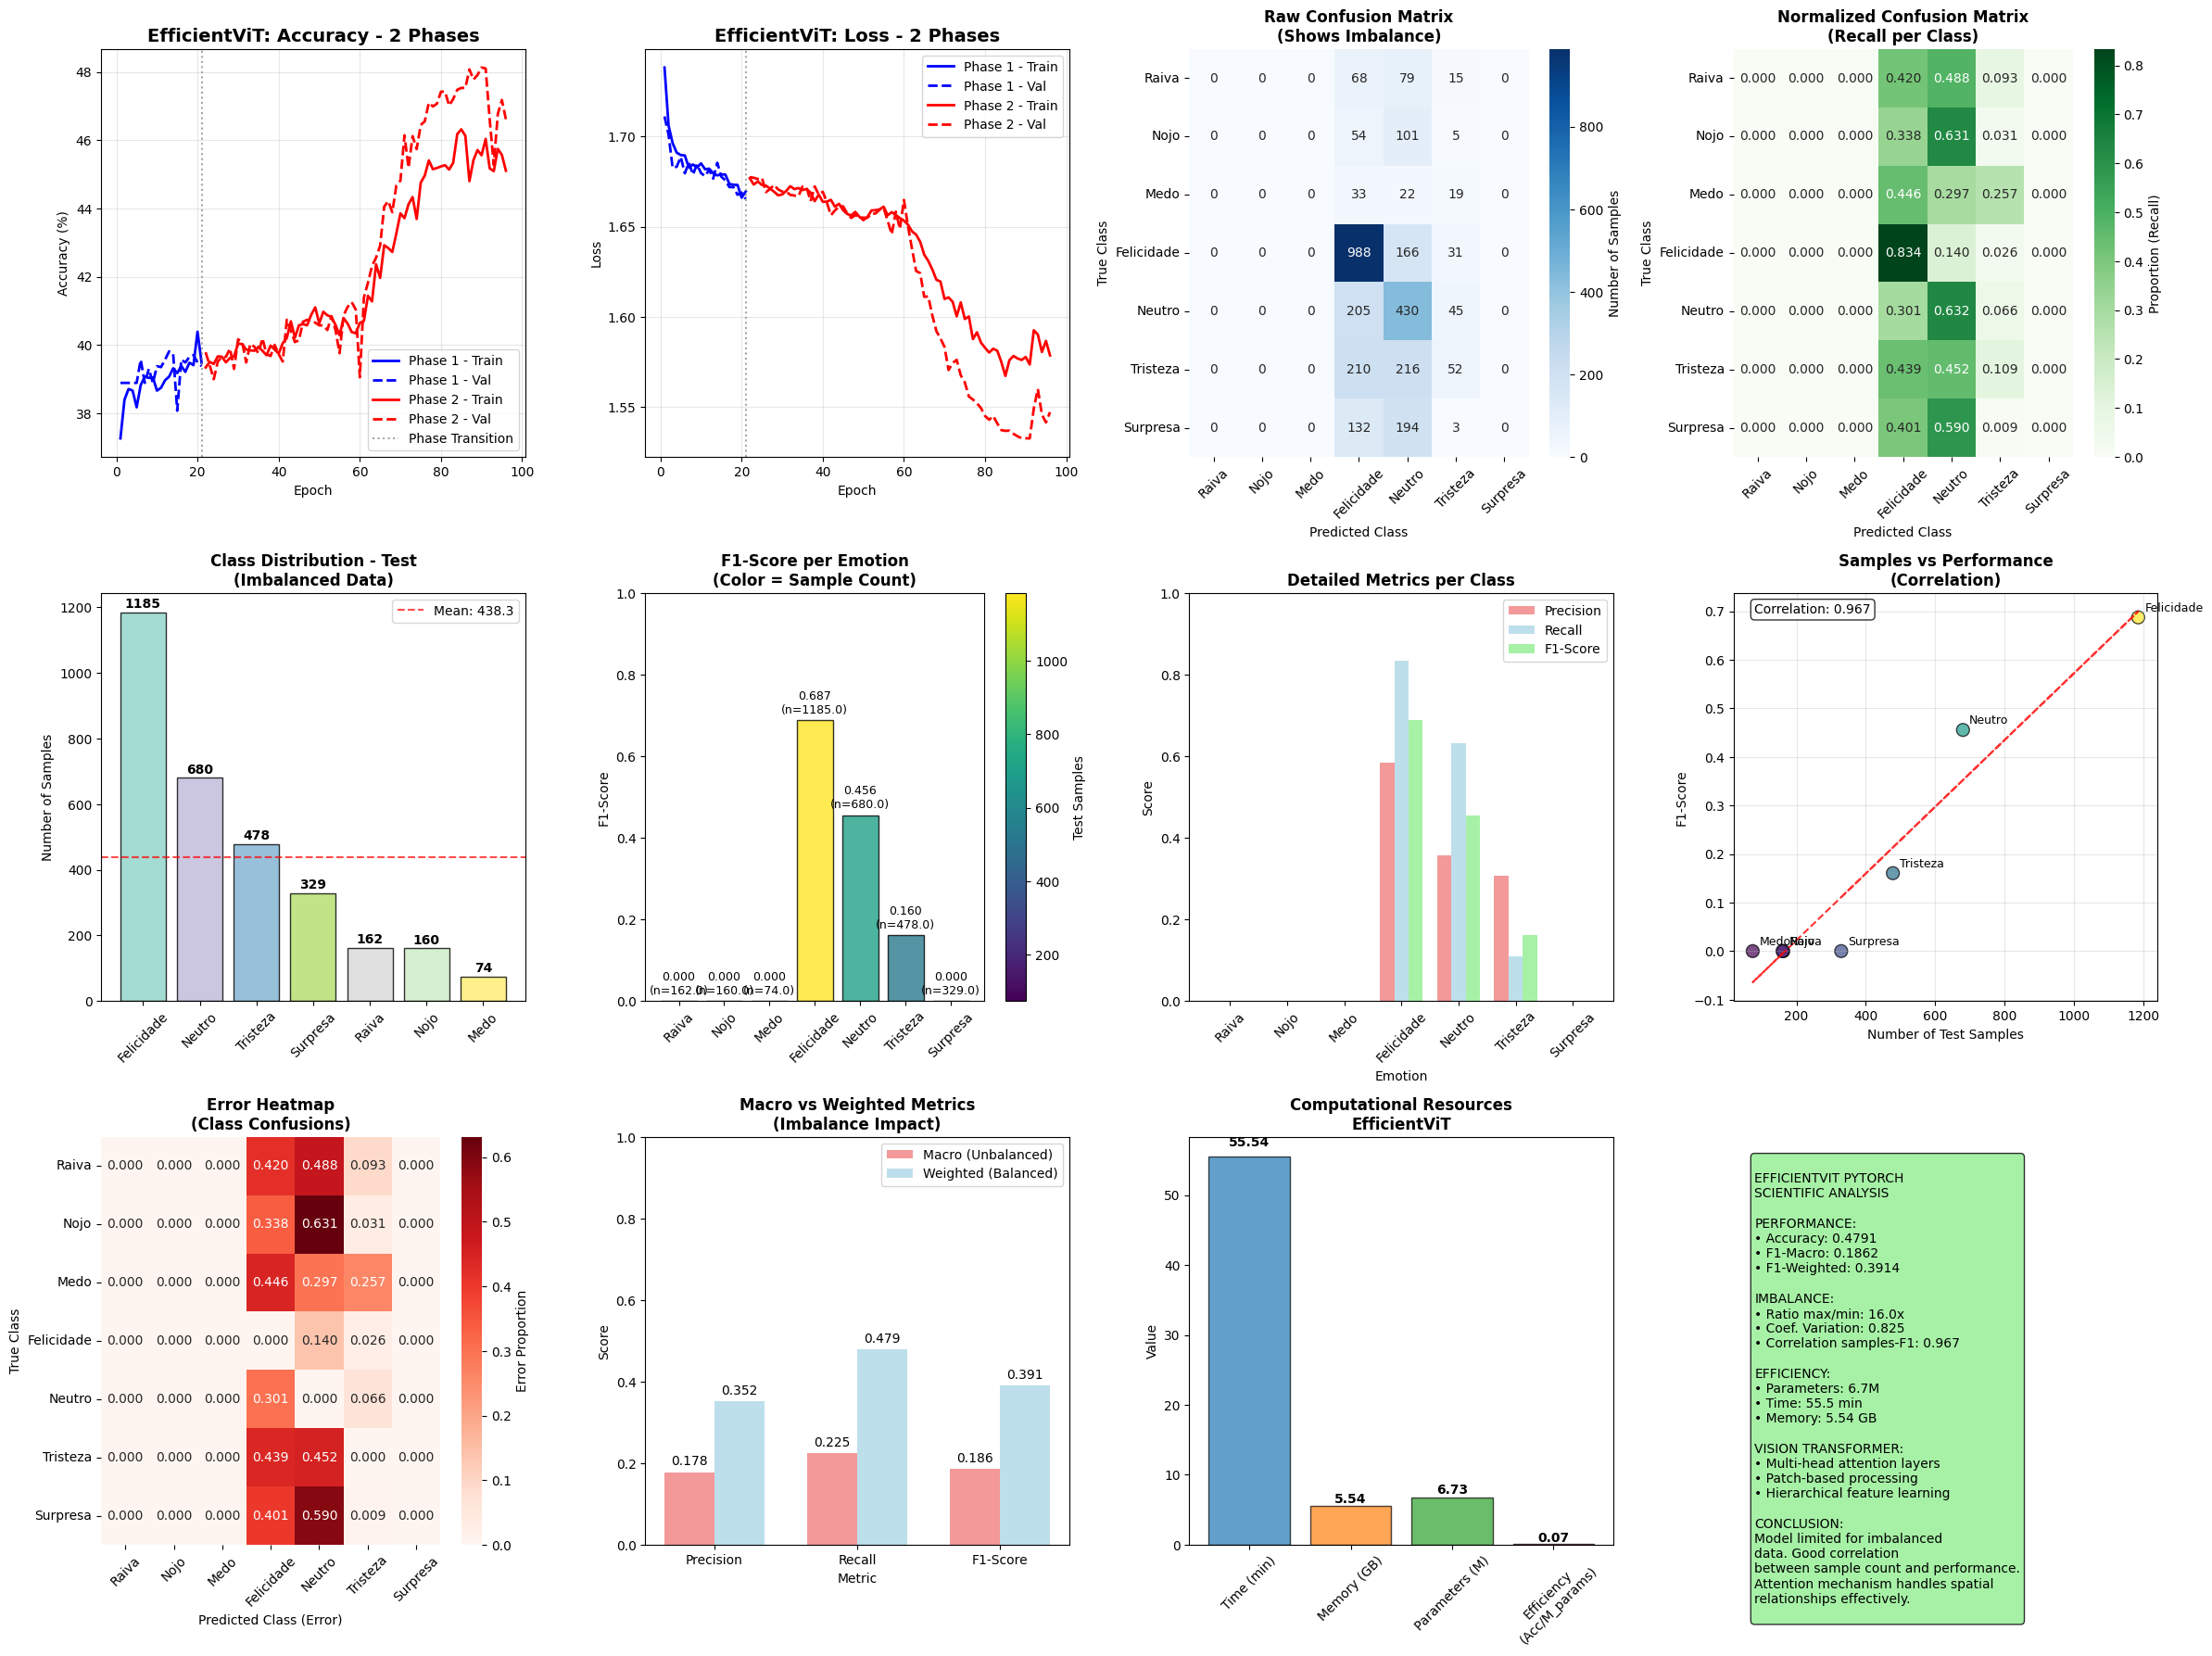


DETAILED ANALYSIS - IMBALANCED DATA
CLASS DISTRIBUTION:
  • Raiva: 162 samples (5.3%)
  • Nojo: 160 samples (5.2%)
  • Medo: 74 samples (2.4%)
  • Felicidade: 1185 samples (38.6%)
  • Neutro: 680 samples (22.2%)
  • Tristeza: 478 samples (15.6%)
  • Surpresa: 329 samples (10.7%)

IMBALANCE STATISTICS:
  • Maximum/minimum ratio: 16.01x
  • Standard deviation: 361.7 samples
  • Coefficient of variation: 0.825
  • Majority class: Felicidade (1185 samples)
  • Minority class: Medo (74 samples)

PERFORMANCE IMPACT:
  • Correlation samples-F1: 0.967
    → STRONG positive correlation: more samples = better F1
  • Best F1: Felicidade (0.687) - 1185.0 samples
  • Worst F1: Raiva (0.000) - 162.0 samples

MAJOR CONFUSIONS:
  • Nojo → Neutro: 0.631
  • Nojo → Neutro: 0.631
  • Surpresa → Neutro: 0.590
  • Raiva → Neutro: 0.488

RECOMMENDATIONS:
  • SEVERE imbalance - consider balancing techniques
  • Suggestions: SMOTE, class weighting, focal loss
  • Consider strategies for minority classes
  • 

In [21]:
# Cell 10: Main Execution Script for EfficientViT

# Main execution
if __name__ == "__main__":
    # Initialize monitor
    monitor = EfficientViTMonitor()
    monitor.start_monitoring()
    
    # Generate experiment ID
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    experiment_id = f"efficientvit_pytorch_emotion_{timestamp}"
    
    # Create output directories
    os.makedirs('plots/efficientvit', exist_ok=True)
    os.makedirs('models/efficientvit', exist_ok=True)
    os.makedirs('metrics/efficientvit', exist_ok=True)
    
    print(f"Experiment ID: {experiment_id}")
    
    # Load data
    print("Loading data...")
    X_train, y_train, X_test, y_test = load_preprocessed_data_efficientvit_from_images()
    
    if X_train is not None:
        # Split training data into train and validation
        X_train_split, X_val, y_train_split, y_val = train_test_split(
            X_train, y_train,
            test_size=VALIDATION_SPLIT,
            stratify=y_train,
            random_state=42
        )
        
        print(f"Data split:")
        print(f"  • Train: {X_train_split.shape}")
        print(f"  • Validation: {X_val.shape}")
        print(f"  • Test: {X_test.shape}")
        
        # Analyze data distribution
        print(f"\nData distribution analysis:")
        unique_train, counts_train = np.unique(y_train_split, return_counts=True)
        unique_test, counts_test = np.unique(y_test, return_counts=True)
        
        emotion_names = list(EMOTION_LABELS.keys())
        print("Training set:")
        for i, count in enumerate(counts_train):
            print(f"  • {emotion_names[i]}: {count} samples")
        
        print("Test set:")
        for i, count in enumerate(counts_test):
            print(f"  • {emotion_names[i]}: {count} samples")
        
        test_imbalance_ratio = max(counts_test) / min(counts_test)
        print(f"Test set imbalance ratio: {test_imbalance_ratio:.1f}:1")
        
        # Create data loaders
        train_loader, val_loader, test_loader = create_data_loaders(
            X_train_split, y_train_split, X_val, y_val, X_test, y_test
        )
        
        # Create EfficientViT model
        print("\nCreating EfficientViT model...")
        model = EfficientViTEmotionClassifier(
            img_size=IMG_SIZE,
            num_classes=7,
            embed_dims=EFFICIENTVIT_CONFIG.get('embed_dims', [64, 128, 192]),
            depths=EFFICIENTVIT_CONFIG.get('depths', [2, 4, 6]),
            num_heads=EFFICIENTVIT_CONFIG.get('num_heads', [2, 4, 6]),
            drop_rate=EFFICIENTVIT_CONFIG['drop_rate'],
            attn_drop_rate=EFFICIENTVIT_CONFIG['attn_drop_rate'],
            drop_path_rate=EFFICIENTVIT_CONFIG['drop_path_rate'],
            dropout_rate=EFFICIENTVIT_CONFIG['dropout_rate']
        )
        model = model.to(device)
        
        # Print model info
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        
        print(f"EfficientViT created successfully:")
        print(f"  • Total parameters: {total_params:,}")
        print(f"  • Trainable parameters: {trainable_params:,}")
        print(f"  • Efficiency: {total_params/1000000:.1f}M parameters")
        print(f"  • Trainable ratio: {(trainable_params/total_params)*100:.1f}%")
        
        # Update monitor with GPU memory if available
        if torch.cuda.is_available():
            initial_gpu_memory = torch.cuda.memory_allocated() / 1024**2  # MB
            print(f"  • Initial GPU memory: {initial_gpu_memory:.1f} MB")
        
        # Train model
        print("\n" + "="*60)
        print("STARTING EFFICIENTVIT TRAINING")
        print("="*60)
        history = train_efficientvit_two_phase(model, train_loader, val_loader, monitor)
        
        # Load best model for evaluation
        if os.path.exists('best_efficientvit_model.pth'):
            model.load_state_dict(torch.load('best_efficientvit_model.pth'))
            print("Loaded best model weights for evaluation")
        
        # Update memory tracking
        monitor.update_peak_memory()
        if torch.cuda.is_available():
            peak_gpu_memory = torch.cuda.max_memory_allocated() / 1024**2  # MB
            print(f"Peak GPU memory: {peak_gpu_memory:.1f} MB")
        
        # Comprehensive evaluation
        print("\n" + "="*60)
        print("CREATING COMPREHENSIVE ANALYSIS")
        print("="*60)
        
        # Detailed evaluation with inference timing
        from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
        
        model.eval()
        all_preds = []
        all_targets = []
        all_probs = []
        inference_times = []
        
        print("Measuring inference performance...")
        with torch.no_grad():
            for i, (data, target) in enumerate(test_loader):
                start_time = time.time()
                data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
                output = model(data)
                probs = F.softmax(output, dim=1)
                inference_time = time.time() - start_time
                inference_times.append(inference_time)
                
                _, predicted = output.max(1)
                all_preds.extend(predicted.cpu().numpy())
                all_targets.extend(target.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
        
        # Calculate comprehensive metrics
        accuracy = accuracy_score(all_targets, all_preds)
        precision, recall, f1, support = precision_recall_fscore_support(
            all_targets, all_preds, average='macro', zero_division=0
        )
        
        # Weighted metrics for imbalanced data
        precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
            all_targets, all_preds, average='weighted', zero_division=0
        )
        
        conf_matrix = confusion_matrix(all_targets, all_preds)
        class_report = classification_report(
            all_targets, all_preds,
            target_names=emotion_names,
            output_dict=True
        )
        
        # Compile comprehensive metrics
        avg_inference_time = np.mean(inference_times)
        total_inference_time = sum(inference_times)
        samples_per_second = len(all_targets) / total_inference_time
        
        metrics = {
            'experiment_id': experiment_id,
            'test_accuracy': accuracy,
            'f1_score_macro': f1,
            'f1_score_weighted': f1_weighted,
            'precision_macro': precision,
            'precision_weighted': precision_weighted,
            'recall_macro': recall,
            'recall_weighted': recall_weighted,
            'training_time_seconds': history['phase1_duration'] + history['phase2_duration'],
            'phase1_duration': history['phase1_duration'],
            'phase2_duration': history['phase2_duration'],
            'peak_memory_mb': monitor.peak_memory_mb,
            'total_parameters': total_params,
            'trainable_parameters': trainable_params,
            'avg_inference_time_seconds': avg_inference_time,
            'samples_per_second': samples_per_second,
            'test_samples': len(all_targets),
            'imbalance_ratio': test_imbalance_ratio,
            'best_val_acc_phase1': history['best_val_acc_phase1'],
            'best_val_acc_phase2': history['best_val_acc_phase2'],
            'model_architecture': 'EfficientViT',
            'embed_dims': EFFICIENTVIT_CONFIG.get('embed_dims', [64, 128, 192]),
            'depths': EFFICIENTVIT_CONFIG.get('depths', [2, 4, 6]),
            'num_heads': EFFICIENTVIT_CONFIG.get('num_heads', [2, 4, 6])
        }
        
        # Print results
        print(f"\nCOMPREHENSIVE RESULTS:")
        print(f"  • Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
        print(f"  • F1-Score (Macro): {f1:.4f}")
        print(f"  • F1-Score (Weighted): {f1_weighted:.4f}")
        print(f"  • Precision (Macro): {precision:.4f}")
        print(f"  • Recall (Macro): {recall:.4f}")
        print(f"  • Inference Speed: {samples_per_second:.1f} samples/second")
        print(f"  • Total Training Time: {timedelta(seconds=int(metrics['training_time_seconds']))}")
        
        # Create comprehensive visualizations with imbalance analysis
        print("\nGenerating comprehensive visualizations...")
        create_comprehensive_visualizations_efficientvit_pytorch(
            history, conf_matrix, metrics, class_report, experiment_id, all_targets, all_preds
        )
        
        # Save model if performance is good
        performance_threshold = 0.70
        if accuracy >= performance_threshold:
            model_path = f'models/efficientvit/efficientvit_model_{experiment_id}.pth'
            torch.save({
                'model_state_dict': model.state_dict(),
                'metrics': metrics,
                'history': history,
                'model_config': {
                    'num_classes': 7,
                    'img_size': IMG_SIZE,
                    'embed_dims': EFFICIENTVIT_CONFIG.get('embed_dims', [64, 128, 192]),
                    'depths': EFFICIENTVIT_CONFIG.get('depths', [2, 4, 6]),
                    'num_heads': EFFICIENTVIT_CONFIG.get('num_heads', [2, 4, 6]),
                    'architecture': 'EfficientViT'
                }
            }, model_path)
            print(f"Model saved: {model_path}")
        else:
            print(f"Model not saved (accuracy {accuracy:.4f} < {performance_threshold})")
        
        # Save metrics to CSV
        metrics_df = pd.DataFrame([metrics])
        metrics_csv = f'metrics/efficientvit/efficientvit_metrics_{experiment_id}.csv'
        metrics_df.to_csv(metrics_csv, index=False)
        print(f"Metrics saved: {metrics_csv}")
        
        # End monitoring
        monitor_stats = monitor.end_monitoring()
        
        print("\n" + "="*60)
        print("EXPERIMENT COMPLETED SUCCESSFULLY")
        print("="*60)
        print(f"Experiment ID: {experiment_id}")
        print(f"Files generated:")
        print(f"  • Visualizations: plots/efficientvit/efficientvit_comprehensive_analysis_pytorch_{experiment_id}.png")
        print(f"  • Metrics: {metrics_csv}")
        if accuracy >= performance_threshold:
            print(f"  • Model: models/efficientvit/efficientvit_model_{experiment_id}.pth")
        print(f"  • Best model: best_efficientvit_model.pth")
        
        # Final summary for imbalanced data
        print(f"\nIMBALANCE ANALYSIS SUMMARY:")
        print(f"  • Test set imbalance ratio: {test_imbalance_ratio:.1f}:1")
        print(f"  • Macro F1 (unweighted): {f1:.4f}")
        print(f"  • Weighted F1 (balanced): {f1_weighted:.4f}")
        print(f"  • Performance difference: {abs(f1_weighted - f1):.4f}")
        
        if f1_weighted - f1 > 0.05:
            print("  → Model benefits significantly from class weighting")
        elif abs(f1_weighted - f1) < 0.02:
            print("  → Model is robust to class imbalance")
        else:
            print("  → Moderate impact of class imbalance")
        
        print(f"\nVISION TRANSFORMER ADVANTAGES:")
        print(f"  • Multi-head attention captures spatial relationships")
        print(f"  • Hierarchical feature learning with {len(EFFICIENTVIT_CONFIG.get('embed_dims', [64, 128, 192]))} stages")
        print(f"  • Efficient attention mechanism reduces computational cost")
        print(f"  • Patch-based processing enables fine-grained analysis")
    
    else:
        print("Failed to load data. Please check the data path and directory structure.")
        print("Expected structure: ../data/augmented/raf_db_balanced/train|test/Emotion_Name/*.jpg")